<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/03_benchmark_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmark Selection (Long-Term + Short-Term) with Regression Analysis

### **Overview**
This notebook implements an automated benchmark selection system for both long-term and short-term trading portfolios using regression analysis. The system identifies the most suitable ETF benchmarks based on sector alignment, fundamental metrics, and statistical relationships.

### **Methodology**
1. **Sector Filtering**: Select ETFs that invest in the same sectors as portfolio holdings
2. **Fundamental Screening**: Filter ETFs by P/E ratio similarity (±20% of portfolio weighted average)
3. **Regression Analysis**: Identify ETFs with highest R² and lowest p-value against portfolio returns
4. **Benchmark Selection**: Choose optimal ETF for performance evaluation
5. **Dual Processing**: Handle both long-term and short-term portfolios simultaneously

### **Key Features**
- Automated sector-based ETF screening
- P/E ratio alignment filtering
- Statistical significance testing
- Visual regression analysis
- Excel export with combined results
- Support for multiple portfolio strategies

## Setup and Configuration

### Import Libraries
All required libraries for data processing, analysis, and visualization.

In [8]:
# UDFs
from py.utils import load_and_filter_data, export_to_excel
from py.regression_benchmark import find_best_benchmark_and_run_regressions, analyze_benchmark_regression, plot_benchmark_analysis

# System and data libraries
import glob, os, ast, re
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

### Configuration Parameters

#### Date Range Setup & Portfolio File Selection
- Configure the analysis period (default: 10 years of historical data)
- Automatically select the most recent portfolio file for analysis.

In [9]:
# Auto-detect latest portfolio and set analysis period
initial_end_date = (datetime.today() - BDay(1)).to_pydatetime()
expected_file = f'portfolios/portfolio-{datetime.date(initial_end_date)}.xlsx'

if os.path.exists(expected_file):
    end_date, output_file = initial_end_date, expected_file
else:
    portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
    output_file = max(portfolio_files, key=os.path.getmtime)
    date_match = re.search(r'portfolio-(\d{4}-\d{2}-\d{2})\.xlsx', output_file)
    end_date = pd.to_datetime(date_match.group(1)).to_pydatetime()

start_date = end_date - timedelta(days=10*365)

# Load configurations and extract parameters
sheets = pd.read_excel(output_file, sheet_name=None)
portfolio_long_df, portfolio_short_df = sheets["long_term_portfolio"], sheets["short_term_portfolio"]

print(f"Analysis Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Duration: {(end_date - start_date).days/365:.2f} years")

Analysis Period: 2015-06-09 to 2025-06-06
Duration: 10.00 years


#### Risk-Free Rate Configuration
Current 13-week Treasury Bill rate for excess return calculations.

In [10]:
# Load current risk-free rate (13-week T-bill)
daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
risk_free_rate_monthly = risk_free_rate / 12

print(f"Current Risk-Free Rate: {risk_free_rate:.4f} (13-week T-bill)")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Current Risk-Free Rate: 0.0423 (13-week T-bill)


## Data Loading and Preprocessing

### ETF Universe Setup
Load and prepare the universe of potential benchmark ETFs with sector weightings.

In [11]:
# Load ETF universe with sector data
sectors_df = pd.read_csv("data/fundamentals_benchmark.csv")[["Ticker", "Name", "Sector Weightings"]]
sectors_df = sectors_df.rename(columns={"Name": "Name", "Ticker": "Symbol", "Sector Weightings": "Sectors"})
sectors_df['Sectors'] = sectors_df['Sectors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip() else {})

print(f"ETF Universe: {len(sectors_df)} potential benchmarks loaded")
display(sectors_df.head())

ETF Universe: 584 potential benchmarks loaded


,Symbol,Name,Sectors
0,AADR,AdvisorShares Dorsey Wright ADR ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.124..."
1,ABFL,Abacus FCF Leaders ETF,"{'realestate': 0.0, 'consumer_cyclical': 0.117..."
2,ACWI,iShares MSCI ACWI ETF,"{'realestate': 0.020499999, 'consumer_cyclical..."
3,ADME,Aptus Drawdown Managed Equity ETF,"{'realestate': 0.0222, 'consumer_cyclical': 0...."
4,AGNG,Global X Aging Population ETF,"{'realestate': 0.0771, 'consumer_cyclical': 0...."


## Portfolio Analysis and Benchmark Selection

### Dual Portfolio Processing
Process both long-term and short-term portfolios with optimized screening and selection logic.


Processing LONG_TERM_PORTFOLIO Portfolio
Portfolio: 5 holdings
After screening: 138 benchmark candidates (P/E range: 17.85-26.78)
Found 131 of 138 tickers in data/daily_benchmark_quotes.csv
Missing tickers: ['AOA', 'EMQQ', 'IJK', 'IVOG', 'MDYG', 'MOAT', 'UPGD']
Found 5 of 5 tickers in data/monthly_stock_quotes.csv
Missing tickers: []
Optimal benchmark: YYY


,Equity,Benchmark,intercept (alpha),slope (beta),correlation,r_squared,p_value_slope,p_value_intercept
0,AMAT,YYY,0.016229,1.535342,0.656091,0.430456,5.541273e-16,0.020835
1,APO,YYY,0.015640,1.608876,0.691523,0.478204,3.140541e-18,0.019306
2,MMC,YYY,0.008916,0.859670,0.687571,0.472754,5.799623e-18,0.013673
3,MRK,YYY,0.001780,0.331593,0.247166,0.061091,6.728627e-03,0.727614
4,TMUS,YYY,0.011370,0.510683,0.371624,0.138104,3.166060e-05,0.024911


📈 BENCHMARK REGRESSION ANALYSIS: YYY
🔍 AMAT: β=1.5353, R²=0.4305, p=0.0000, Weight=22.9%
🔍 APO: β=1.6089, R²=0.4782, p=0.0000, Weight=8.4%
🔍 MMC: β=0.8597, R²=0.4728, p=0.0000, Weight=31.8%
🔍 MRK: β=0.3316, R²=0.0611, p=0.0067, Weight=14.5%
🔍 TMUS: β=0.5107, R²=0.1381, p=0.0000, Weight=22.4%


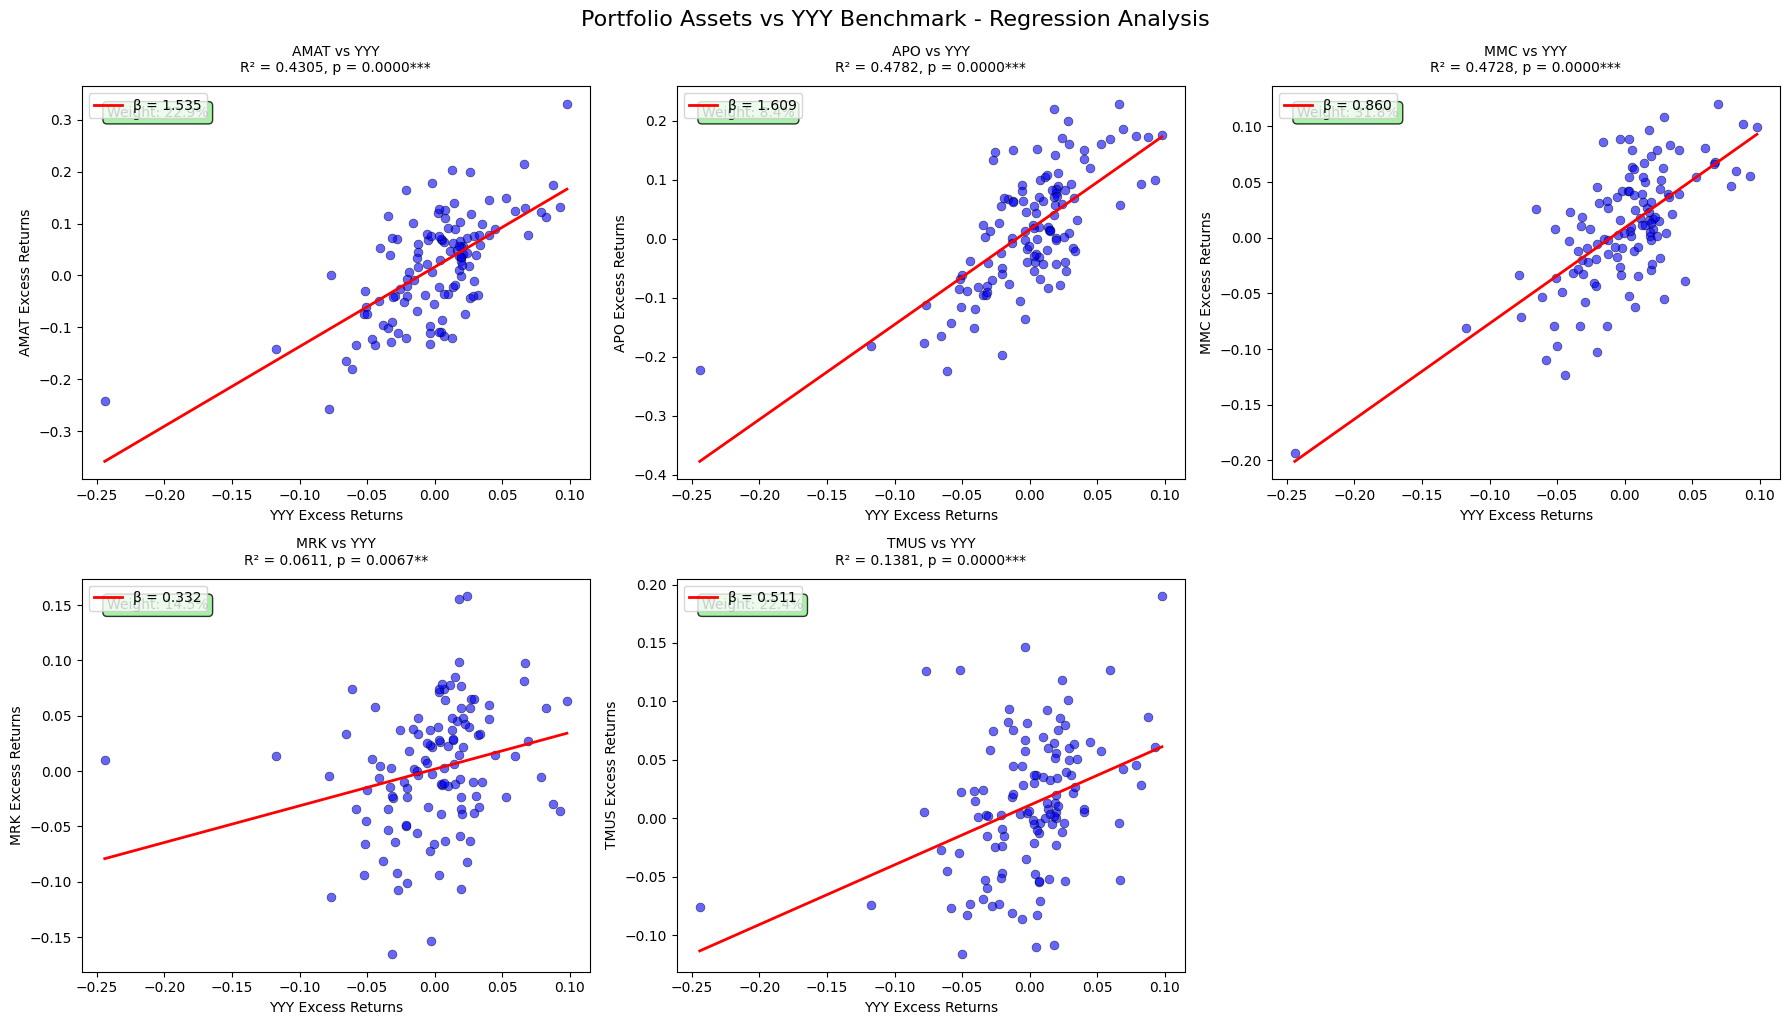


📊 BENCHMARK REGRESSION SUMMARY: YYY


,Ticker,Beta,Alpha,R_Squared,Correlation,P_Value,Portfolio_Weight,N_Observations,Significance
0,AMAT,1.5353,0.0162,0.4305,0.6561,0.0000,0.2289,119,***
1,APO,1.6089,0.0156,0.4782,0.6915,0.0000,0.0840,119,***
2,MMC,0.8597,0.0089,0.4728,0.6876,0.0000,0.3181,119,***
3,MRK,0.3316,0.0018,0.0611,0.2472,0.0067,0.1453,119,**
4,TMUS,0.5107,0.0114,0.1381,0.3716,0.0000,0.2237,119,***



📈 PORTFOLIO STATISTICS: Weighted β=0.9225, Weighted R²=0.3289
  • Significant relationships (p<0.05): 5/5
Portfolio sectors: {'Technology', 'Financial Services', 'Healthcare', 'Communication Services'}
Benchmark sectors: {'Utilities', 'Energy', 'Technology', 'Healthcare', 'Communication Services', 'Consumer Defensive', 'Industrials', 'Consumer Cyclical', 'Basic Materials', 'Financial Services', 'Realestate'}


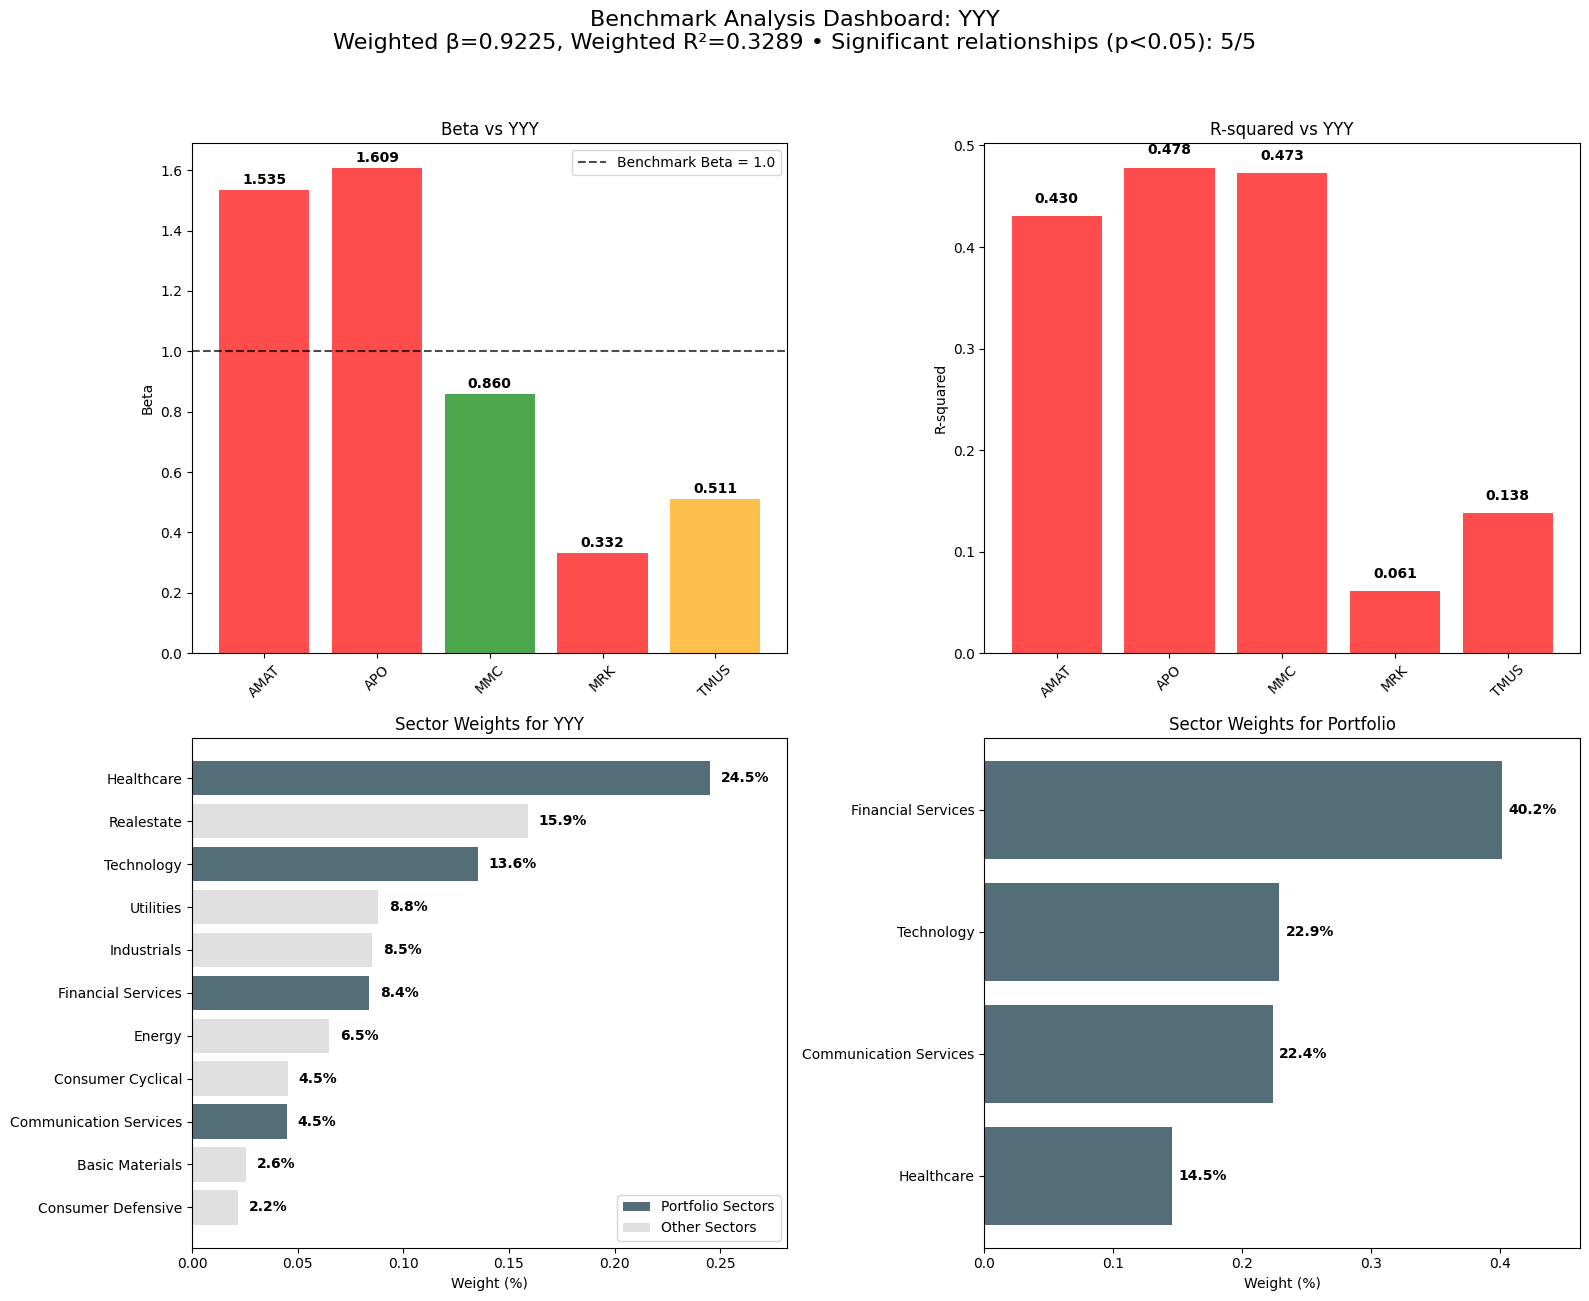


Processing SHORT_TERM_PORTFOLIO Portfolio
Portfolio: 2 holdings
After screening: 110 benchmark candidates (P/E range: 21.88-32.82)
Found 105 of 110 tickers in data/daily_benchmark_quotes.csv
Missing tickers: ['FTXL', 'KNG', 'MOAT', 'PSCI', 'PTNQ']
Found 2 of 2 tickers in data/monthly_stock_quotes.csv
Missing tickers: []
Optimal benchmark: XRLV


,Equity,Benchmark,intercept (alpha),slope (beta),correlation,r_squared,p_value_slope,p_value_intercept
0,MSFT,XRLV,0.013634,0.788884,0.541153,0.292846,2.097725e-10,0.003627
1,NOC,XRLV,0.003256,0.748869,0.497322,0.247329,8.733531e-09,0.507203


📈 BENCHMARK REGRESSION ANALYSIS: XRLV
🔍 MSFT: β=0.7889, R²=0.2928, p=0.0000, Weight=50.0%
🔍 NOC: β=0.7489, R²=0.2473, p=0.0000, Weight=50.0%


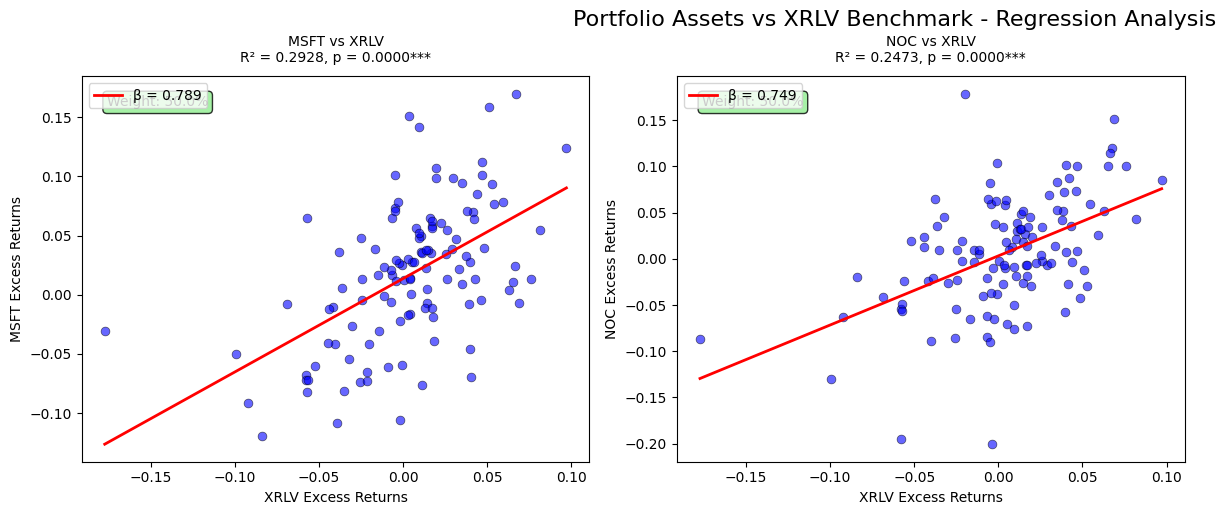


📊 BENCHMARK REGRESSION SUMMARY: XRLV


,Ticker,Beta,Alpha,R_Squared,Correlation,P_Value,Portfolio_Weight,N_Observations,Significance
0,MSFT,0.7889,0.0136,0.2928,0.5412,0.0,0.5,119,***
1,NOC,0.7489,0.0033,0.2473,0.4973,0.0,0.5,119,***



📈 PORTFOLIO STATISTICS: Weighted β=0.7689, Weighted R²=0.2701
  • Significant relationships (p<0.05): 2/2
Portfolio sectors: {'Industrials', 'Technology'}
Benchmark sectors: {'Utilities', 'Energy', 'Technology', 'Healthcare', 'Communication Services', 'Realestate', 'Industrials', 'Consumer Cyclical', 'Basic Materials', 'Financial Services', 'Consumer Defensive'}


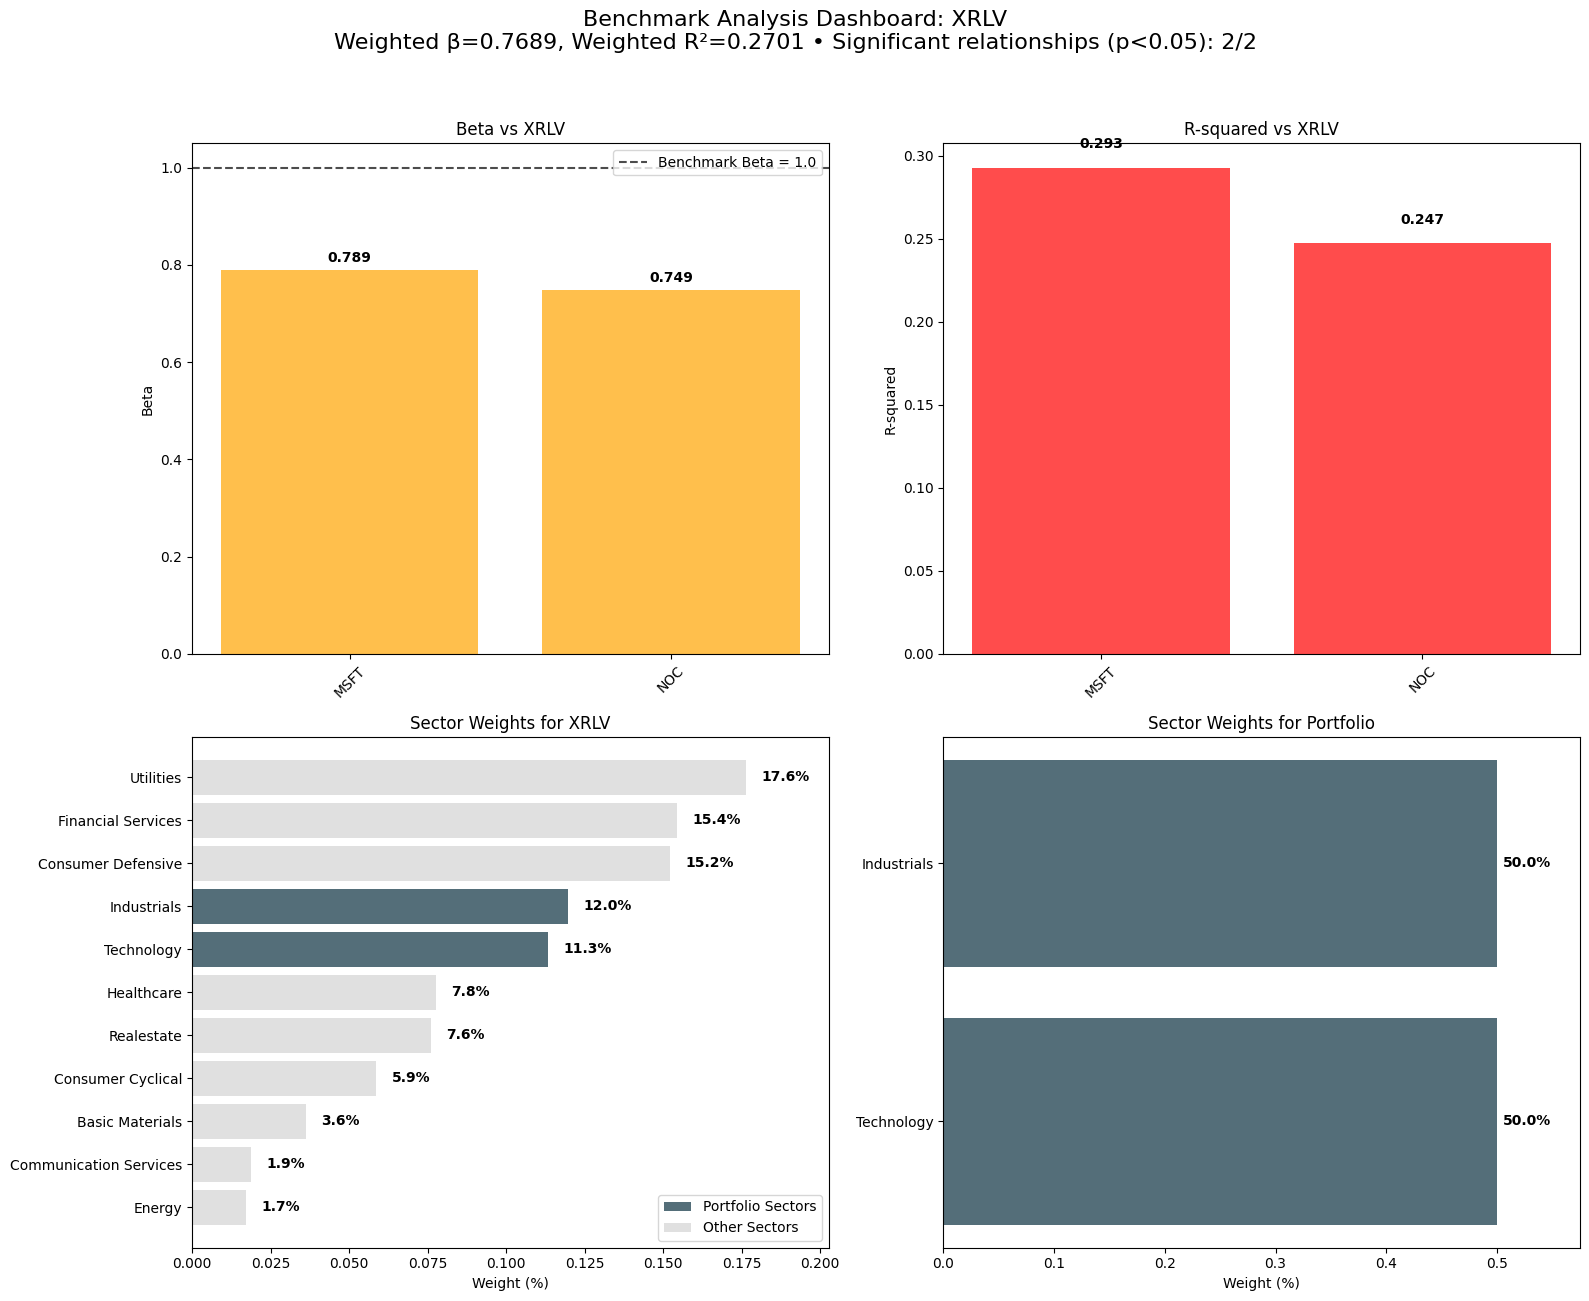

In [12]:
portfolio_types = ["long_term_portfolio", "short_term_portfolio"]
results = {}

for portfolio_type in portfolio_types:
    print(f"\n{'='*50}\nProcessing {portfolio_type.upper()} Portfolio\n{'='*50}")
    
    # Load portfolio data
    portfolio_df = pd.read_excel(output_file, sheet_name=portfolio_type)
    portfolio_tickers = portfolio_df["Ticker"].tolist()
    pe_column = "P/E (trailing)" if "P/E (trailing)" in portfolio_df.columns else "P/E (Trailing)"
    portfolio_df[pe_column] = pd.to_numeric(portfolio_df[pe_column], errors="coerce")
    
    print(f"Portfolio: {len(portfolio_tickers)} holdings")
    
    # Sector-based ETF filtering
    portfolio_sectors = [sector.strip().lower().replace(" ", "_") for sector in 
                        portfolio_df.groupby('Sector')['Weight'].sum().sort_values(ascending=False).index]
    
    filtered_etfs = sectors_df[sectors_df['Sectors'].apply(
        lambda d: isinstance(d, dict) and all(sector in d and d[sector] > 0 for sector in portfolio_sectors)
    )].reset_index(drop=True)
    
    # P/E ratio filtering
    fundamentals_df = pd.read_csv("data/fundamentals_benchmark.csv", index_col="Ticker")
    merged_df = pd.merge(filtered_etfs, fundamentals_df.reset_index().rename(columns={'Ticker': 'Symbol'}), 
                        on='Symbol', how='inner')
    
    weighted_avg_pe = (portfolio_df["Weight"] * portfolio_df[pe_column]).sum()
    pe_range = (weighted_avg_pe * 0.8, weighted_avg_pe * 1.2)
    
    final_etfs = merged_df[(merged_df["P/E (trailing)"] >= pe_range[0]) & 
                          (merged_df["P/E (trailing)"] <= pe_range[1])]
    tickers = final_etfs["Symbol"].tolist()
    
    print(f"After screening: {len(tickers)} benchmark candidates (P/E range: {pe_range[0]:.2f}-{pe_range[1]:.2f})")
    
    # Load and prepare price data
    benchmark_daily = load_and_filter_data('data/daily_benchmark_quotes.csv', tickers, start_date, end_date)
    stock_monthly = load_and_filter_data('data/monthly_stock_quotes.csv', portfolio_tickers, start_date, end_date)
    
    # Clean data (remove tickers with missing values in first/last 50 observations)
    null_check = benchmark_daily.head(50).isnull().any() | benchmark_daily.tail(50).isnull().any()
    benchmark_daily = benchmark_daily.loc[:, ~null_check]
    
    # Convert to monthly and calculate excess returns
    # Handle different data structures (with or without Date column)
    if 'Date' in benchmark_daily.columns:
        benchmark_monthly = (benchmark_daily.set_index(pd.to_datetime(benchmark_daily.pop('Date')))
                            .resample('MS').last().reset_index().rename(columns={'index': 'Date'}).set_index('Date'))
    else:
        # Data already has DatetimeIndex
        benchmark_monthly = benchmark_daily.resample('MS').last()
    
    benchmark_excess = np.log(benchmark_monthly / benchmark_monthly.shift(1)).dropna() - risk_free_rate_monthly
    stock_excess = np.log(stock_monthly / stock_monthly.shift(1)).dropna() - risk_free_rate_monthly
    
    # Find optimal benchmark
    best_benchmark, stats_df, best_df = find_best_benchmark_and_run_regressions(benchmark_excess, stock_excess)
    
    print(f"Optimal benchmark: {best_benchmark}")
    display(best_df)
    
    # Generate analysis plots
    regression_results = analyze_benchmark_regression(benchmark_excess, stock_excess, best_benchmark, portfolio_df)
    benchmark_info = final_etfs[final_etfs["Symbol"] == best_benchmark][["Symbol", "Name_x", "Sectors"]].rename(columns={"Name_x": "Name"})
    
    # Fix function call - pass parameters correctly
    plot_benchmark_analysis(
        regression_results=regression_results, 
        best_benchmark=best_benchmark, 
        cols=3,
        benchmark_sectors_df=benchmark_info,
        portfolio_df=portfolio_df
    )
    
    # Store results
    best_df.set_index(best_df.columns[0], inplace=True)
    results[portfolio_type] = {
        'best_benchmarks_df': best_df,
        'benchmark_prices_daily_df': benchmark_daily[[best_benchmark]],
        'benchmark_prices_monthly_df': benchmark_monthly[[best_benchmark]],
        'best_benchmark': best_benchmark
    }

## Results Export and Summary

### Excel Export with Combined Results
Export benchmark selections and price data to Excel with organized sheets.

In [13]:
# Prepare consolidated export data
export_data = {f'benchmark_{pt}': results[pt]['best_benchmarks_df'] for pt in portfolio_types}

# Combine price data (same benchmark = single sheet, different = separate columns)
lt_benchmark, st_benchmark = results['long_term_portfolio']['best_benchmark'], results['short_term_portfolio']['best_benchmark']

if lt_benchmark == st_benchmark:
    export_data.update({
        'daily_quotes': results['long_term_portfolio']['benchmark_prices_daily_df'],
        'monthly_quotes': results['long_term_portfolio']['benchmark_prices_monthly_df']
    })
else:
    export_data.update({
        'daily_quotes': pd.concat([results['long_term_portfolio']['benchmark_prices_daily_df'], 
                                 results['short_term_portfolio']['benchmark_prices_daily_df']], axis=1),
        'monthly_quotes': pd.concat([results['long_term_portfolio']['benchmark_prices_monthly_df'], 
                                   results['short_term_portfolio']['benchmark_prices_monthly_df']], axis=1)
    })

# Export and summarize
export_to_excel(output_file, export_data)

print(f"\n{'='*60}")
print("BENCHMARK SELECTION SUMMARY")
print(f"{'='*60}")
print(f"Long-term Portfolio: {lt_benchmark}")
print(f"Short-term Portfolio: {st_benchmark}")
print(f"Results exported to: {output_file}")
print(f"{'='*60}")

Updated sheet 'benchmark_long_term_portfolio'
Updated sheet 'benchmark_short_term_portfolio'
Successfully merged data into 'daily_quotes' sheet
Successfully merged data into 'monthly_quotes' sheet
Successfully exported all data to portfolios/portfolio-2025-06-06.xlsx

BENCHMARK SELECTION SUMMARY
Long-term Portfolio: YYY
Short-term Portfolio: XRLV
Results exported to: portfolios/portfolio-2025-06-06.xlsx
